# FACE RECOGNITION

A facial recognition system is a technology capable of using Neural networks in identifying or verifying a person from a digital image or a video frame from a video source. Here we are using a pretrained model for training and the webcam image for verification

Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). and  [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf). 

The crux of the code and all the functions are all from the Coursera Deep learning specialization by deeplearning.ai & Andrew Ng

In [1]:
########### IMPORTING ALL THE LIBRARIES #############
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


# Facenet:

Despite significant recent advances in the field of face recognition, implementing face verification and recognition efficiently at scale presents serious challenges to current approaches. In this paper we present a system, called FaceNet, that directly learns a mapping from face images to a compact Euclidean space where distances directly correspond to a measure of face similarity. Once this space has been produced, tasks such as face recognition, verification and clustering can be easily implemented using standard techniques with FaceNet embeddings as feature vectors. 

The FaceNet model takes a lot of data and a long time to train. So following common practice in applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al.*](https://arxiv.org/abs/1409.4842). We have provided an inception network implementation. You can look in the file `inception_blocks.py` to see how it is implemented.  


In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead


# Implementation:

This network uses 96x96 dimensional RGB images as its input and outputs a matrix that encodes each input face image into a 128-dimensional vector

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings the compare two face images as follows:

So, an encoding is a good one if: 
- The encodings of two images of the same person are quite similar to each other 
- The encodings of two images of different persons are very different

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart. 




In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


# Triplet Loss:


Our network computes a 128-dimensional embedding on a unit hypersphere and is optimized with a triplet loss function as defined in the FaceNet paper. A triplet is a 3-tuple of an anchor embedding, positive embedding (of the same person), and negative embedding (of a different person). The triplet loss minimizes the distance between the anchor and positive and penalizes small distances between the anchor and negative that are “too close.”

The figure below captures the gist of the triplet loss function

![alt text](https://qph.ec.quoracdn.net/main-qimg-0356408039ea97772ace326378ed6ff2.webp)


In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))    
    return loss

## Compiling the model and loading weights from the FACENET implementation

In [5]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Crop and resize the original image

In [28]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.imread('images/san.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

crop_img = img[y:y+h, x:x+w]
res = cv2.resize(crop_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
img = Image.fromarray(res, 'RGB')
img.save('images/san_cropped.jpg')

In [53]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.imread('images/sacha.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

crop_img = img[y:y+h, x:x+w]
res = cv2.resize(crop_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
img = Image.fromarray(res, 'RGB')
img.save('images/sacha_cropped.jpg')

In [58]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.imread('images/borat.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

crop_img = img[y:y+h, x:x+w]
res = cv2.resize(crop_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
img = Image.fromarray(res, 'RGB')
img.save('images/borat_cropped.jpg')

In [66]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.imread('images/actualborat.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

crop_img = img[y:y+h, x:x+w]
res = cv2.resize(crop_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
img = Image.fromarray(res, 'RGB')
img.save('images/actualborat_cropped.jpg')

## Save the image to a database containing the faces

In [6]:
database = {}
database["sangarshanan"] = img_to_encoding("images/san_cropped.jpg", FRmodel)

In [55]:
database["borat"] = img_to_encoding("images/sacha_cropped.jpg", FRmodel)

## The face verification function that computes the distance between images

In [7]:
def verify(image_path, identity, database, model):
    encoding =  img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding - database[identity])
    if dist < 0.7:
        print("Hey, it's " + str(identity) + ", Hello!")
        boolean = True
    else:
        print("I think it's not " + str(identity) + ", Sorry ")
        boolean = False        
    return dist, boolean

## Take an image using your webcam 

In [21]:
import cv2
import numpy as np
from PIL import Image


cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    cv2.imshow("Press SPACE to take a picture and ESC to close", frame)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        print("Camera Closed")
        break
    elif k%256 == 32:
        img_name = "webcam_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        res = cv2.imread(img_name)
        img = Image.fromarray(res, 'RGB')
        img.save('images/webcam.jpg')    
        print("{} has been added".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()

webcam_0.png has been added
Camera Closed


## Crop out the our face and resize the image to 96*96

In [22]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img = cv2.imread('images/webcam.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

crop_img = img[y:y+h, x:x+w]
res = cv2.resize(crop_img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
img = Image.fromarray(res, 'RGB')
img.save('images/webcam.jpg')

In [36]:
verify("images/webcam.jpg", 'sangarshanan' , database, FRmodel)

Hey, it's sangarshanan, Hello!


(0.63073266, True)

############## IT'S A MATCH ###################


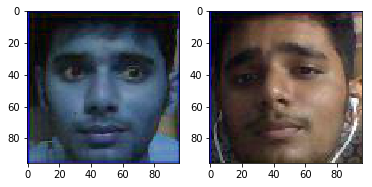

In [40]:
img1 = cv2.imread('images/webcam.jpg')
img2 = cv2.imread('images/san_cropped.jpg')
print("############## IT'S A MATCH ###################")
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)

In [60]:
verify("images/borat_cropped.jpg", 'borat' , database, FRmodel)

Hey, it's borat, Hello!


(0.6851243, True)

############## IT'S A MATCH ###################


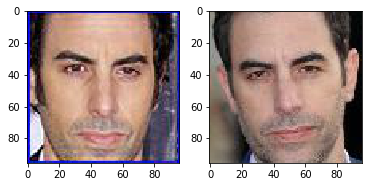

In [61]:
img1 = cv2.imread('images/borat_cropped.jpg')
img2 = cv2.imread('images/sacha_cropped.jpg')
print("############## IT'S A MATCH ###################")
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)

In [65]:
verify("images/san_cropped.jpg", 'borat' , database, FRmodel)

I think it's not borat, Sorry 


(1.2283788, False)

############## IT'S A MISMATCH ###################


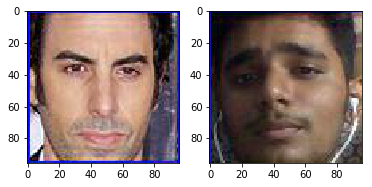

In [64]:
img1 = cv2.imread('images/borat_cropped.jpg')
img2 = cv2.imread('images/san_cropped.jpg')
print("############## IT'S A MISMATCH ###################")
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)

In [67]:
verify("images/actualborat_cropped.jpg", 'borat' , database, FRmodel)

I think it's not borat, Sorry 


(0.7948964, False)

############## IT'S A MISMATCH ###################


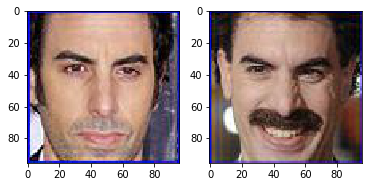

In [68]:
img1 = cv2.imread('images/borat_cropped.jpg')
img2 = cv2.imread('images/actualborat_cropped.jpg')
print("############## IT'S A MISMATCH ###################")
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)

## Well.....it looks like Borat can fool our model

In [69]:
def verify(image_path, identity, database, model):
    encoding =  img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding - database[identity])
    if dist < 1:
        print("Hey, it's " + str(identity) + ", Hello!")
        boolean = True
    else:
        print("I think it's not " + str(identity) + ", Sorry ")
        boolean = False        
    return dist, boolean

## Maybe we need to be a bit lenient with the threshold or improve our model

In [70]:
verify("images/actualborat_cropped.jpg", 'borat' , database, FRmodel)

Hey, it's borat, Hello!


(0.7948964, True)